1) In  a  Notebook,  create  a  custom  loading  class,  compatible  with  Pytorch DataLoader, that generates training triplets (anchor, positive example, negative example) from 20 Newsgroups. You  might  want  to  take  a  look  at the SentenceLabelDataset class https://github.com/UKPLab/sentence-transformers/blob/6fcfdfb30f9dfcc5fb978c97ce02941a7aa6ba63/sentence_transformers/datasets/SentenceLabelDataset.py.You should come up with a strategy to generate triplets that will be the most helpful / insightful for the model to train with.
---




---

The picture below shows the areas where different vectorized sentences within the radius of our anchor may occur. In theory, for better results, we should focus on examples in a 'semi-hard negatives' area for our anchor sentence.
---
I used this article https://omoindrot.github.io/triplet-loss#a-naive-implementation-of-triplet-loss
---
In order to do that, I propose the following strategy for triplet generation: for positive samples, use another sentence with the same label as the anchor but which has one of maximum distances (randomly chosen one of highest 10%)  from current ancher sentence, and for negative samples, use sentences with any labels neighbouring in a cluster with the label of anchor sentence (if there is only one example in the cluster, then use all other labels) which has one of the minimum distances from the curent anchor.So we take the hardest positive and the hardest negative example.
---
Thus, the training will focus on maximizing the distance between labels that are semantically very close, but have different labels and minimizing the radius of the clutser of sentences which have the same label.  
---
To find the examples in the 'semi-hard negatives' area, I used the results of the not fine-tuned knn classifier on a test set (confusion matrix of the results) and found out how close the topics (labels in this case) are to each other, then built a cluster list. The cluster structure can be improved, it's only proof-of-concept, but it's used as an approximation for the search of the closest semi-hard negatives in entire dataset, because of memory and/or time constraints. 
---
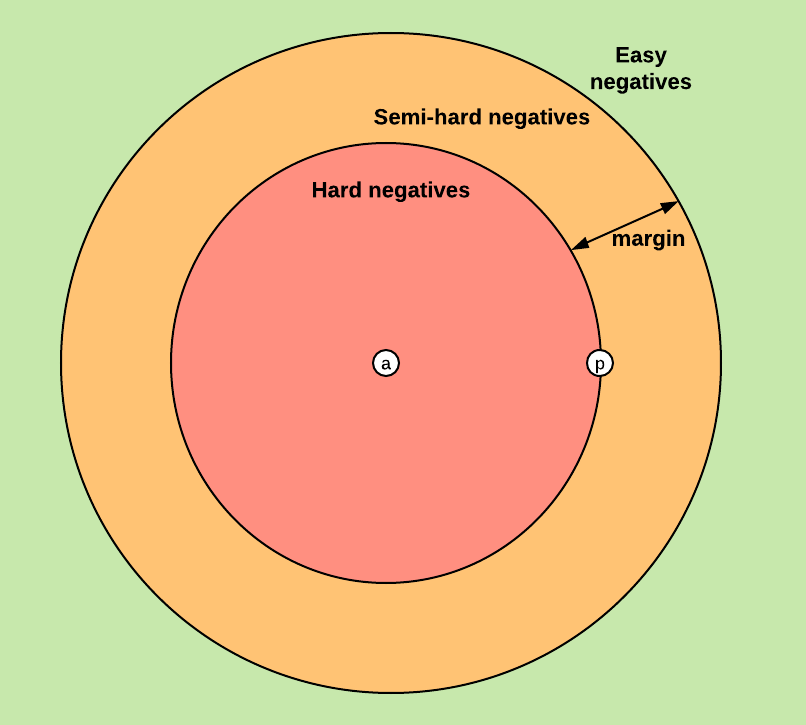


---

## Import of all the necessary libraries


In [2]:
!pip install -U sentence-transformers
import numpy as np
import torch
from tqdm import tqdm

from sentence_transformers import (
    SentenceTransformer,
    losses,
    models
)
from typing import List
import bisect

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch

from sentence_transformers.readers import InputExample
from sentence_transformers.evaluation import TripletEvaluator
from sentence_transformers.datasets import SentenceLabelDataset
from datetime import datetime


import logging
import os
import urllib.request
import random
from collections import defaultdict

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 778kB 14.2MB/s 
     |████████████████████████████████| 890kB 29.6MB/s 
     |████████████████████████████████| 3.0MB 51.0MB/s 
     |████████████████████████████████| 1.1MB 46.8MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.4-cp36-none-any.whl size=99830 sha256=e97379f2311360810d1baa85e9e44ded22781e75d7b645805f482976ea711a9e
  Stored in directory: /root/.cache/pip/wheels/39/b3/0a/c25bcdeeb0858f691d377f06d4bbf5e735598fa3a54d01c04f
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=0c32666a429a5d4a81ea50720912ed721fbeef59253d9fefd790782520aa3d5f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


## Dataset class implementation based on a SentencLabelDataset

In [ ]:

CLUSTERS = [[19, 15, 0], [16], [12], [8], [7], [4], [3], [1, 5, 2, 14, 17], [13, 11, 6], [18, 10, 9]]


class ClusteredSentenceLabelDataset(Dataset):
  """
    Dataset for training with triplet loss.
    This dataset takes a list of sentences grouped by their label and uses this grouping to dynamically select a
    positive example from the same group and a negative example from the other sentences for a selected anchor sentence.
    This dataset should be used in combination with dataset_reader.LabelSentenceReader
    One iteration over this dataset selects every sentence as anchor once.
    This also uses smart batching like SentenceDataset.
  """
  def __init__(self, examples: List[InputExample], model: SentenceTransformer, provide_positive: bool = True,
                  provide_negative: bool = True, clusters: List[List] = CLUSTERS):
    """
        Converts input examples to a ClusteredSentenceLabelDataset usable to train the model with
        SentenceTransformer.smart_batching_collate as the collate_fn for the DataLoader
        Assumes only one sentence per InputExample and labels as integers from 0 to max_num_labels
        and should be used in combination with dataset_reader.LabelSentenceReader.
        Labels with only one example are ignored.
        smart_batching_collate as collate_fn is required because it transforms the tokenized texts to the tensors.
        :param examples:
            the input examples for the training
        :param model
            the Sentence BERT model for the conversion
        :param provide_positive:
            set this to False, if you don't need a positive example (e.g. for BATCH_HARD_TRIPLET_LOSS).
        :param provide_negative:
            set this to False, if you don't need a negative example (e.g. for BATCH_HARD_TRIPLET_LOSS
            or MULTIPLE_NEGATIVES_RANKING_LOSS).
        :param clusters:
            the structure of clusters in a form of two nested lists
    """
    self.model = model
    

    self.provide_positive = provide_positive
    self.provide_negative = provide_negative
    self.groups_right_border = []
    self.grouped_inputs = []
    self.grouped_labels = []
    self.items = []
    self.embeddings = []
    self.clusters = clusters
    self.distinct_labels_num = 0
    

    self.convert_input_examples(examples, model)
    self.idxs = np.arange(len(self.grouped_inputs))
    

    

  def convert_input_examples(self, examples: List[InputExample], model: SentenceTransformer):
    """
        Converts input examples to a ClusteredSentenceLabelDataset.
        Assumes only one sentence per InputExample and labels as integers from 0 to max_num_labels
        and should be used in combination with dataset_reader.LabelSentenceReader.
        Labels with only one example are ignored.
        :param examples:
            the input examples for the training
        :param model
            the Sentence Transformer model for the conversion
    """
    inputs = []
    labels = []

    label_sent_mapping = {}
    too_long = 0
    label_type = None

    # Group examples and labels
    # Add examples with the same label to the same dict
    for ex_index, example in enumerate(tqdm(examples, desc="Convert dataset")):
        if label_type is None:
            if isinstance(example.label, int):
                label_type = torch.long
            elif isinstance(example.label, float):
                label_type = torch.float
        tokenized_text = model.tokenize(example.texts[0])

        if hasattr(model, 'max_seq_length') and model.max_seq_length is not None and model.max_seq_length > 0 and len(tokenized_text) > model.max_seq_length:
            too_long += 1

        if example.label in label_sent_mapping:
            label_sent_mapping[example.label].append(ex_index)
        else:
            label_sent_mapping[example.label] = [ex_index]

        inputs.append(tokenized_text)
        labels.append(example.label)

    # Group sentences, such that sentences with the same label
    # are besides each other. Only take labels with at least 2 examples
    distinct_labels = list(label_sent_mapping.keys())
    self.distinct_labels_num = len(distinct_labels)
    for i in range(self.distinct_labels_num):
        label = distinct_labels[i]
        if len(label_sent_mapping[label]) >= 2:
            self.grouped_inputs.extend([inputs[j] for j in label_sent_mapping[label]])
            self.grouped_labels.extend([labels[j] for j in label_sent_mapping[label]])
            self.groups_right_border.append(len(self.grouped_inputs)) #At which position does this label group / bucket end?

    self.grouped_labels = torch.tensor(self.grouped_labels, dtype=label_type)
    self.grouped_inputs = np.array(self.grouped_inputs)

    # Calculate the embeddings for a sentences, used in distance calculation afterwards 
    self.embeddings = self.model.encode(self.grouped_inputs, is_pretokenized=True)
    logging.info("Num sentences: %d" % (len(self.grouped_inputs)))
    logging.info("Sentences longer than max_seqence_length: {}".format(too_long))
    logging.info("Number of labels with >1 examples: {}".format(len(distinct_labels)))

  
  def __len__(self):
    return len(self.grouped_inputs)
    
  def __getitem__(self, item):
    if not self.provide_positive and not self.provide_negative:
        return [self.grouped_inputs[item]], self.grouped_labels[item]
    label = self.grouped_labels[item]
    anchor = self.grouped_inputs[item]


    group_idx = bisect.bisect_right(self.groups_right_border, item)
    left_border = 0 if group_idx == 0 else self.groups_right_border[group_idx - 1]
    right_border = self.groups_right_border[group_idx]
    positive_idxs = np.concatenate([self.idxs[left_border:item], self.idxs[item + 1:right_border]])

    # Take the labels of negative sentences in a cluster with the anchor
    negative_group_labels = self.all_labels_inside_cluster(int(label))
    if len(negative_group_labels) == 1:
      negative_group_labels = [i for i in range(self.distinct_labels_num)]
    negative_group_labels.remove(int(label))
    
    # Taking the indexes of the sentences in a cluster
    negative_idxs = np.argwhere(
        np.any([np.array(self.grouped_labels, dtype=np.int64) == i for i in negative_group_labels], axis=0))[:, 0]
    
    # Finding random from k closest negative and the most distant positive  
    positive_idx, negative_idx = self._pairwise_distances(self.embeddings[item], self.embeddings[positive_idxs], self.embeddings[negative_idxs])
    positive_ret = self.grouped_inputs[positive_idxs[positive_idx]]
    negative_ret = self.grouped_inputs[negative_idxs[negative_idx]]

    if self.provide_positive:
        positive = positive_ret
    else:
        positive = []

    if self.provide_negative:
        negative = negative_ret
    else:
        negative = []

    return [anchor, positive, negative], self.grouped_labels[item]

  # Supplementary function that adds the filtering of indexes using cluster structure
  def all_labels_inside_cluster(self, label: int):
    negative_group_idxs = [cluster for cluster in self.clusters if label in cluster]
    return sorted(*negative_group_idxs)

  # Calculating the distances from anchor sentences to other array of vectors (euclidean metric)
  # and take random sample of 10 % closest negative and the most distant positive sentences
  def _pairwise_distances(self, vector, pos_embs, neg_embs):
    pos_k = int(0.1 * len(pos_embs)) + 1
    neg_k = int(0.1 * len(neg_embs)) + 1
    pos_dist = (pos_embs - vector)**2
    pos_dist = np.sum(pos_dist, axis=1) 
    pos_dist = np.where(pos_dist < 0, 0, pos_dist)

    neg_dist = (neg_embs - vector)**2
    neg_dist = np.sum(neg_dist, axis=1) 
    neg_dist = np.where(neg_dist < 0, 0, neg_dist)
    return int(np.random.choice(np.argpartition(pos_dist, -pos_k)[-pos_k:])), int(np.random.choice(np.argpartition(neg_dist, neg_k)[:neg_k]))

In [3]:
from sklearn.datasets import fetch_20newsgroups


def get_data(split_ratios: List[float]):
  newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), return_X_y=True, shuffle=True)
  examples = []
  guid = 0
  for texts, label in zip(newsgroups_all[0], newsgroups_all[1]):
    for text in texts.replace('\n','').replace('\t',' ').split('.'):
      if text != "" and text != " ":
        examples.append(InputExample(guid=guid, texts=[text], label=label))
        guid += 1
  
  n = len(examples)
  # Split the data in given ratios (split_ratios[0] + split_ratios[1] < 1)
  train_set = examples[:int(n*split_ratios[0])]
  validation_set = examples[int(n*split_ratios[0]):int(n*(split_ratios[0] + split_ratios[1]))]
  test_set = examples[int(n*(split_ratios[0] + split_ratios[1])):]
  return train_set, validation_set, test_set    

split_ratios = [0.7, 0.15]
train_set, validation_set, test_set = get_data(split_ratios) 
print(len(train_set), len(validation_set), len(test_set))

180180 38610 38610


2) Build a training pipeline and fine-tune a distilbert-base-nli-mean-tokens model with your custom loading class, using the TripletLoss *loss* function.Since fine-tuning is quite time-consuming, even on a GPU, you can go for a single epoch. Your triplet generation strategy is what matters to us.
---

## Getting and cleaning the data

## Defining and fine-tuning the model

In [4]:
from google.colab import drive
drive.mount('/gdrive')
base_path = '/gdrive/My Drive/data/'



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
logging.basicConfig(level=logging.DEBUG)

In [ ]:
# Model params
model_name = 'distilbert-base-nli-mean-tokens'
train_batch_size = 16
output_path = (
    base_path
    +"finetune-batch-hard-trec-"
    + model_name
    + "-"
    + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)
num_epochs = 1

# Train dataset loss and model
model = SentenceTransformer(model_name)
train_dataset = ClusteredSentenceLabelDataset(
    examples=train_set,
    model=model,
    provide_positive=True, 
    provide_negative=True,
)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)
train_loss = losses.TripletLoss(model=model)

INFO:root:Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens
INFO:root:Did not find a '/' or '\' in the name. Assume to download model from server.
INFO:root:Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_distilbert-base-nli-mean-tokens.zip
INFO:transformers.configuration_utils:loading configuration file /root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_distilbert-base-nli-mean-tokens.zip/0_Transformer/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  

INFO:root:Num sentences: 180180
INFO:root:Sentences longer than max_seqence_length: 2206
INFO:root:Number of labels with >1 examples: 20


In [ ]:
def triplets_from_labeled_dataset(input_examples):
    # Create triplets for a [(label, sentence), (label, sentence)...] dataset
    # by using each example as an anchor and selecting randomly a
    # positive instance with the same label and a negative instance with a different label
    triplets = []
    label2sentence = defaultdict(list)
    for inp_example in input_examples:
        label2sentence[inp_example.label].append(inp_example)

    for inp_example in tqdm(input_examples, desc="Convert dataset"):
        anchor = inp_example

        if len(label2sentence[inp_example.label]) < 2: #We need at least 2 examples per label to create a triplet
            continue

        positive = None
        while positive is None or positive.guid == anchor.guid:
            positive = random.choice(label2sentence[inp_example.label])

        negative = None
        while negative is None or negative.label == anchor.label:
            negative = random.choice(input_examples)

        triplets.append(InputExample(texts=[anchor.texts[0], positive.texts[0], negative.texts[0]]))

    return triplets

validation_examples = triplets_from_labeled_dataset(validation_set)
test_examples = triplets_from_labeled_dataset(test_set)

Convert dataset: 100%|██████████| 38610/38610 [00:00<00:00, 191619.76it/s]


## Model training

In [ ]:
evaluator = TripletEvaluator.from_input_examples(validation_examples, name='dev')
warmup_steps = int(len(train_dataset) * num_epochs / train_batch_size * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=5000,
          warmup_steps=warmup_steps,
          output_path=output_path)

INFO:root:TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 5000 steps:
INFO:root:Accuracy Cosine Distance:   	58.75
INFO:root:Accuracy Manhatten Distance:	54.26
INFO:root:Accuracy Euclidean Distance:	54.26

INFO:root:Save model to /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46
INFO:transformers.configuration_utils:Configuration saved in /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46/0_Transformer/config.json
INFO:transformers.modeling_utils:Model weights saved in /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46/0_Transformer/pytorch_model.bin
INFO:root:TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 10000 steps:
INFO:root:Accuracy Cosine Distance:   	63.19
INFO:root:Accuracy Manhatten Distance:	57.11
INFO:root:Accuracy Euclidean Distance:	57.15

INFO:root:Save model to /gdrive/My Drive/data

INFO:root:Accuracy Cosine Distance:   	63.43
INFO:root:Accuracy Manhatten Distance:	57.15
INFO:root:Accuracy Euclidean Distance:	57.22

INFO:root:Save model to /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46
INFO:transformers.configuration_utils:Configuration saved in /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46/0_Transformer/config.json
INFO:transformers.modeling_utils:Model weights saved in /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46/0_Transformer/pytorch_model.bin


## Testing the fine-tuned model on a Triplet Evaluator

In [ ]:
# Testing of the fine-tuned model
model = SentenceTransformer(output_path)


# Evaluation
test_evaluator = TripletEvaluator.from_input_examples(test_examples, name='test')
test_evaluator(model, output_path=output_path)

INFO:root:Load pretrained SentenceTransformer: /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46
INFO:root:Load SentenceTransformer from folder: /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46
INFO:transformers.configuration_utils:loading configuration file /gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46/0_Transformer/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 30522
}

INFO:transfo

0.6111888111888112

## Testing of the base (not fine-tuned) model on a Triplet Evaluator

In [ ]:
# Testing of the fine-tuned model
model_name = 'distilbert-base-nli-mean-tokens'
base_model = SentenceTransformer(model_name)


# Evaluation
test_evaluator = TripletEvaluator.from_input_examples(test_examples, name='test')
test_evaluator(base_model, output_path=output_path)

INFO:root:Load pretrained SentenceTransformer: distilbert-base-nli-mean-tokens
INFO:root:Did not find a '/' or '\' in the name. Assume to download model from server.
INFO:root:Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_distilbert-base-nli-mean-tokens.zip
INFO:transformers.configuration_utils:loading configuration file /root/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_distilbert-base-nli-mean-tokens.zip/0_Transformer/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  

0.5596995596995596

3) Do some research online to find an Approximate Nearest Neighbor library. There are many of them and there really is no wrong choice. But we expect you to explain your pick in a few words.
---


---





I've chosen [FAISS](https://github.com/facebookresearch/faiss) library as it's quite popular and have extensive 
---

community. Also FAISS offers more options, especially for really large scale scenarios. I also looked at Annoy and NGT libraries because of their simple interfaces. 
--- 

---

4) Build a basic prediction pipeline:
---
a.Vectorize the training set with your fine-tuned sBERT model
---
b.Index all these vectors with your ANN library
---
c.Build a barebone kNN classifier where new text input gets predicted the same label as that of the closest neighbor from the index
---
d.Benchmark this pipeline with the test set
---
e.Compare the results with the pretrained sBERT model
---



In [5]:
!pip install faiss
!apt-get install libopenblas-dev
!apt-get install libomp-dev
import faiss
from sklearn.datasets import fetch_20newsgroups
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

     |████████████████████████████████| 4.7MB 4.4MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-dev is already the newest version (0.2.20+ds-4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com

## Code for prediction pipeline class

In [6]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(18, 16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [7]:
class KNN_Predictor():
  """
    Pipeline for sentences' classification based on a KNN algorithm 
    used on a 20 Newsgroup dataset vectorized with sBERT (uses ANN for faster search of the nearest sentences)
  """
  def __init__(self, model: SentenceTransformer, examples: List[InputExample] = None, 
               embedding_size: int = 768, n_clusters: int = 1024):
    """
        Constructs the predictor. 
        Vectorizes the dataset using provided model and indexes it using FAISS ANN library
        :param model
            the Sentence BERT model for the conversion
        :param examples:
            the input examples for the training. If None, Predictor will download the dataset 
        :param embedding_size:
            size of embedding vectors
        :param n_clusters:
            Number of clusters used for faiss. Select a value 4*sqrt(N) to 16*sqrt(N) 
            - https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index
    """
    self.embedding_size = embedding_size
    self.n_clusters = n_clusters
    self.corpus_embeddings = []
    self.labels = []
    self.index = None
    self.model = model
    self.get_all_sentence_label_pairs(examples)
    self.index_all_embeddings()
    print('')
    print('Predictor constructed')

  def get_all_sentence_label_pairs(self, examples):
    if examples == None:
      print('No dataset provided')
      print('Dataset downloading')
      newsgroups_all = fetch_20newsgroups(subset='all', 
                                          remove=('headers', 'footers', 'quotes'), 
                                          return_X_y=True)
      sentences = []
      for ex_index, example in enumerate(tqdm(zip(newsgroups_all[0], newsgroups_all[1]), desc="Dataset vectorization")):
        texts = example[0]
        label = example[1]
        for text in texts.replace('\n','').replace('\t',' ').split('.'):
          sentences.append(text)
          self.labels.append(label)
    else:
      print('Dataset processing')
      sentences = [x.texts[0] for x in examples]
      self.labels = [x.label for x in examples]
      
    print('')
    print('Construction of embeddings')
    self.corpus_embeddings = self.model.encode(sentences)

  def index_all_embeddings(self):
    print('Indexing of all embeddings')
    quantizer = faiss.IndexFlatIP(self.embedding_size)
    self.index = faiss.IndexIVFFlat(quantizer, self.embedding_size, 
                                    self.n_clusters, faiss.METRIC_INNER_PRODUCT)
    self.corpus_embeddings = self.corpus_embeddings / np.linalg.norm(self.corpus_embeddings, axis=1)[:, None]
    self.index.train(self.corpus_embeddings)
    self.index.add(self.corpus_embeddings)

  def knn(self, question_embedding, k):
    # Question vector normalization 
    question_embedding = question_embedding / np.linalg.norm(question_embedding)
    question_embedding = np.expand_dims(question_embedding, axis=0)
    
    # Making request and getting labels for k nearest vectors
    distances, corpus_ids = self.index.search(question_embedding, k)
    k_nearest_labels = []
    for id in corpus_ids[0]:
      k_nearest_labels.append(self.labels[id])
    
    # Return mode of the sequence
    return Counter(k_nearest_labels).most_common(1)[0][0]
      
  def predict(self, query, k):
    question_embedding = self.model.encode(query)

    return self.knn(question_embedding, k)

## Benchmark of the base model

In [8]:
print(len(test_set))
test_set.extend(validation_set)
print(len(test_set))

38610
77220


In [9]:
k = 3
model_name = 'distilbert-base-nli-mean-tokens'
base_model = SentenceTransformer(model_name)
predictor = KNN_Predictor(base_model, train_set)

100%|██████████| 245M/245M [00:15<00:00, 15.5MB/s]


Dataset processing

Construction of embeddings
Indexing of all embeddings

Predictor constructed


In [10]:
labels_pred = []
for ex_index, example in enumerate(tqdm(test_set, desc="Predictions generation")):
  labels_pred.append(predictor.predict(example.texts[0], k))
labels_true = [x.label for x in test_set]

print('')
print('Base model accuracy: ', accuracy_score(labels_true, labels_pred))
print('Base model classification report: ')
print(classification_report(labels_true, labels_pred, labels=[i for i in range(20)]))
base_matrix = confusion_matrix(labels_true, labels_pred)

Predictions generation: 100%|██████████| 77220/77220 [11:27<00:00, 112.35it/s]



Base model accuracy:  0.363986013986014
Base model classification report: 
              precision    recall  f1-score   support

           0       0.23      0.22      0.23      3035
           1       0.29      0.46      0.36      3816
           2       0.56      0.57      0.57      6274
           3       0.18      0.20      0.19      2598
           4       0.23      0.21      0.22      2889
           5       0.38      0.47      0.42      5200
           6       0.35      0.40      0.37      2674
           7       0.24      0.26      0.25      2114
           8       0.26      0.26      0.26      1850
           9       0.51      0.47      0.49      3549
          10       0.53      0.50      0.51      4488
          11       0.34      0.35      0.34      4654
          12       0.21      0.18      0.20      2706
          13       0.38      0.38      0.38      4543
          14       0.46      0.33      0.39      4461
          15       0.40      0.37      0.38      5255
     

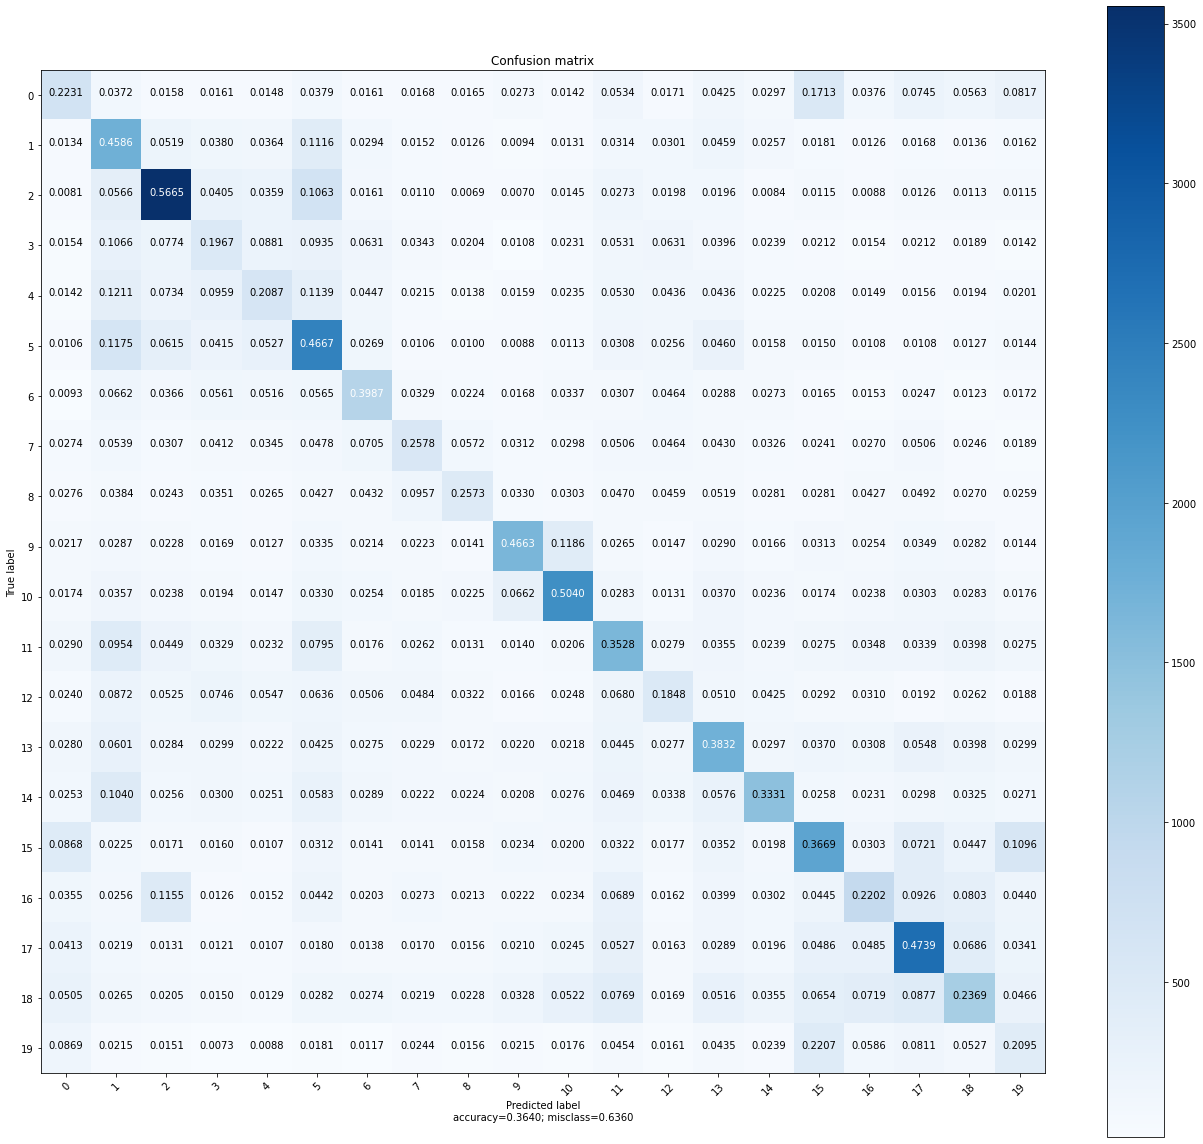

In [11]:
plot_confusion_matrix(confusion_matrix(labels_true, labels_pred), [i for i in range(20)])

## Benchmark of the fine-tuned model

In [13]:
output_path = "/gdrive/My Drive/data/finetune-batch-hard-trec-distilbert-base-nli-mean-tokens-2020-08-30_23-51-46"
model = SentenceTransformer(output_path)
predictor = KNN_Predictor(model, train_set)
labels_pred = []
for ex_index, example in enumerate(tqdm(test_set, desc="Predictions generation")):
  labels_pred.append(predictor.predict(example.texts[0], k))
labels_true = [x.label for x in test_set]
print('')
print('Fine-tuned model accuracy: ', accuracy_score(labels_true, labels_pred))
print('Fine-tuned model classification report: ')
print(classification_report(labels_true, labels_pred, labels=[i for i in range(20)]))
fine_matrix = confusion_matrix(labels_true, labels_pred)

Dataset processing

Construction of embeddings
Indexing of all embeddings


Predictions generation:   0%|          | 11/77220 [00:00<11:51, 108.47it/s]


Predictor constructed


Predictions generation: 100%|██████████| 77220/77220 [11:57<00:00, 107.55it/s]



Fine-tuned model accuracy:  0.40165760165760167
Fine-tuned model classification report: 
              precision    recall  f1-score   support

           0       0.26      0.22      0.24      3035
           1       0.30      0.45      0.36      3816
           2       0.53      0.52      0.52      6274
           3       0.21      0.21      0.21      2598
           4       0.24      0.21      0.23      2889
           5       0.47      0.53      0.50      5200
           6       0.28      0.37      0.32      2674
           7       0.23      0.25      0.24      2114
           8       0.21      0.24      0.23      1850
           9       0.58      0.59      0.59      3549
          10       0.68      0.61      0.64      4488
          11       0.44      0.45      0.45      4654
          12       0.20      0.17      0.18      2706
          13       0.44      0.52      0.47      4543
          14       0.51      0.43      0.47      4461
          15       0.35      0.25      0.29  

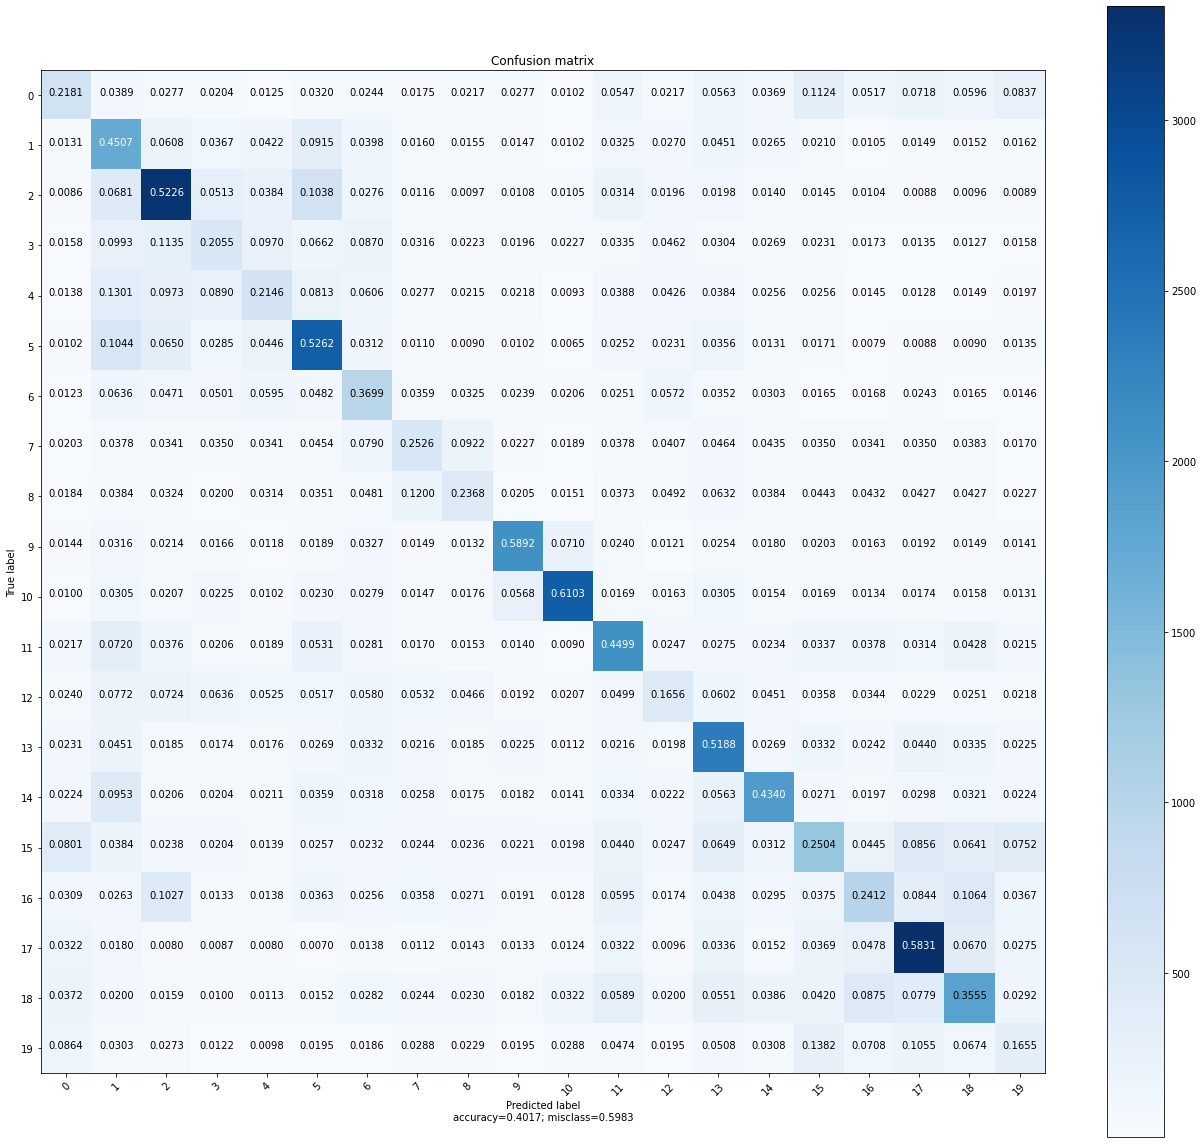

In [14]:
plot_confusion_matrix(confusion_matrix(labels_true, labels_pred), [i for i in range(20)])